In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/VaibhavData/Datasets/modified_xray_pneumonia.zip

In [3]:
EPOCHS = 30
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [4]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

### Data Preparation

In [5]:
# Directory paths for train, validation, and test sets
train_dir = '/content/xray_pneumonia/train'
test_dir = '/content/xray_pneumonia/test'
val_dir = '/content/xray_pneumonia/val'

In [6]:
# Expand the single-channel greyscale image into three channels
def expand_greyscale_image_channels(image):
    return np.repeat(image[:, :, np.newaxis], 3, axis=-1)

# Data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# Generate batches of augmented data for train, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    color_mode='rgb'
)

Found 6505 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
print(train_generator.image_shape)
print("Number of images in train_generator:", train_generator.n)
print("Number of images in test_generator:", test_generator.n)
print("Number of images in val_generator:", val_generator.n)

(224, 224, 3)
Number of images in train_generator: 6505
Number of images in test_generator: 624
Number of images in val_generator: 16


In [ ]:
pip install keras vit-keras tensorflow tensorflow-addons

In [10]:
import tensorflow as tf
import tensorflow_addons as tfa
from vit_keras import vit

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Model Training

In [11]:

# Define ViT-B/32 model
vit_model = vit.vit_b32(
        image_size = 224,
        activation = 'sigmoid',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, 'sigmoid')
    ],
    name = 'vision_transformer')

model.summary()


353253686/353253686 [==============================] - 5s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (Batch  (None, 768)               3072      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               196864    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 1)          

In [13]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# model_checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/VaibhavData/modelsV2/vit/vitL32_pneumonia_detection.tf', save_best_only=True, monitor='accuracy', mode='max', verbose=1)

# Train the model with callbacks
history = model.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    # callbacks=[model_checkpoint],
    verbose=1
)

Epoch 1/30
204/204 [==============================] - 152s 549ms/step - loss: 0.6134 - accuracy: 0.7127 - val_loss: 1.0879 - val_accuracy: 0.5000
Epoch 2/30
204/204 [==============================] - 110s 539ms/step - loss: 0.4724 - accuracy: 0.7708 - val_loss: 0.8200 - val_accuracy: 0.5000
Epoch 3/30
204/204 [==============================] - 109s 535ms/step - loss: 0.4167 - accuracy: 0.8065 - val_loss: 0.6672 - val_accuracy: 0.6875
Epoch 4/30
204/204 [==============================] - 110s 540ms/step - loss: 0.3932 - accuracy: 0.8177 - val_loss: 0.7434 - val_accuracy: 0.5000
Epoch 5/30
204/204 [==============================] - 109s 535ms/step - loss: 0.3874 - accuracy: 0.8228 - val_loss: 0.7290 - val_accuracy: 0.5625
Epoch 6/30
204/204 [==============================] - 110s 539ms/step - loss: 0.3659 - accuracy: 0.8341 - val_loss: 1.3828 - val_accuracy: 0.5000
Epoch 7/30
204/204 [==============================] - 110s 538ms/step - loss: 0.3479 - accuracy: 0.8504 - val_loss: 0.9961 -

In [14]:
# Save the trained model
model.save('/content/drive/MyDrive/VaibhavData/modelsV2/vit/vitB32_pneumonia_detection.tf')

In [15]:
# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(train_generator)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

204/204 [==============================] - 110s 538ms/step - loss: 0.2134 - accuracy: 0.9174
Train Loss: 0.2133546620607376
Train Accuracy: 0.917448103427887


In [16]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

20/20 [==============================] - 5s 219ms/step - loss: 0.4306 - accuracy: 0.8157
Test Loss: 0.4306367337703705
Test Accuracy: 0.8157051205635071


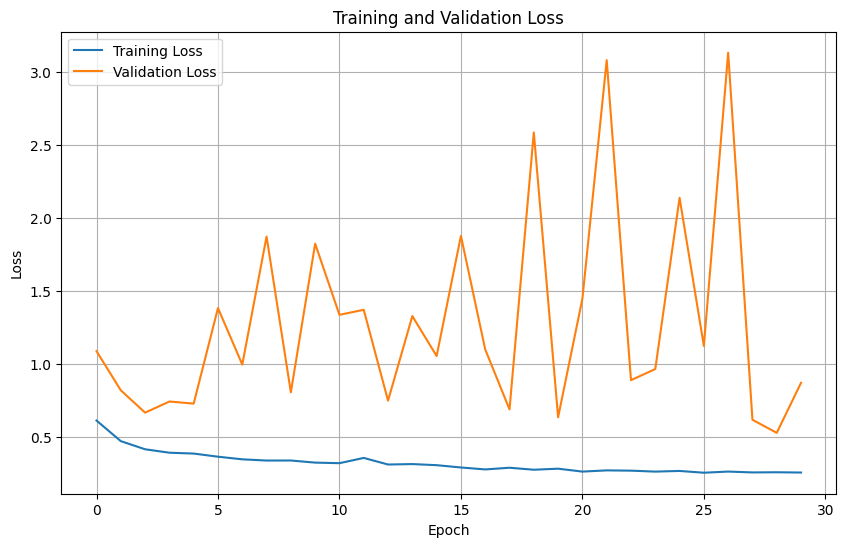

<function matplotlib.pyplot.show(close=None, block=None)>

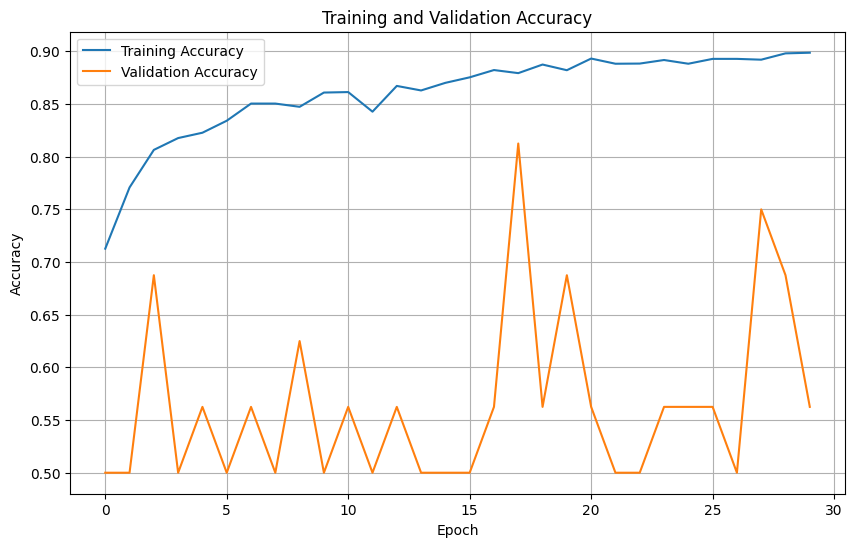

In [17]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/VaibhavData/images/vitb_training_validation_loss.png')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/VaibhavData/images/vitb_training_validation_accuracy.png')
plt.show

### Load model

In [11]:
# Once training is complete, load the best model
model = tf.keras.models.load_model('/content/drive/MyDrive/VaibhavData/modelsV2/vit/vitB32_pneumonia_detection.tf')

In [12]:
# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(train_generator)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

204/204 [==============================] - 334s 2s/step - loss: 0.2168 - accuracy: 0.9153
Train Loss: 0.2167598307132721
Train Accuracy: 0.9152958989143372


In [13]:
# Evaluate the best model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

20/20 [==============================] - 31s 2s/step - loss: 0.4306 - accuracy: 0.8157
Test Loss: 0.43063676357269287
Test Accuracy: 0.8157051205635071
